![](./figures/Logo.PNG)

In [1]:
import matplotlib.pyplot as plt

## In this part of the tutorial, you will
* analyse dynamic model outputs visually
* analyse the model residuals (the difference between observed and simulated)

- - -

# 2a - Visual Model Output Inspection

- - -

## 1. Model Outputs

To understand the quality of our model, we assess the model outputs. 

A key initial step in model output analysis is visual inspection of the simulated **time series** (Blue Box 1) using various plots. 
Where observations are available, these can be compared with the simulation results.
The [**residual**](https://en.wikipedia.org/wiki/Errors_and_residuals), quantifying where the model results are close and far from the observed values, is another helpful tool. 

The [**Box-Cox Transformation**](https://doi.org/10.1111/j.2517-6161.1964.tb00553.x          ) (Blue Box 2) can highlight aspects of analysed time series.

**Scatterplots** of observed values against simulated results (Blue Box 3) display over-/ underprediction. 

Additionally, we may study the **residual** (Blue Box 4). 

---

## 2. Visual Inspection of Model Output

**Import packages**

In [2]:
import sys
sys.path.append('src/')
import scipy
import random
import HyMod
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from ipywidgets import interact, Dropdown

### 2.1. Read Catchment Data, Prepare Model Input

In [3]:
# DO NOT ALTER! code to select the catchment

l_catchment_names = ["Medina River, TX, USA", "Siletz River, OR, USA", "Trout River, BC, Canada"]
l_catchment_filenames = ["camels_08178880", "camels_14305500", "hysets_10BE007"]

catchment_dropdown = Dropdown(options=zip(l_catchment_names, l_catchment_filenames),
                              value=l_catchment_filenames[0],
                              description="Catchment:",
                              disabled=False)
display(catchment_dropdown)

Dropdown(description='Catchment:', options=(('Medina River, TX, USA', 'camels_08178880'), ('Siletz River, OR, …

In [4]:
catchment_file = catchment_dropdown.value
catchment_name = l_catchment_names[l_catchment_filenames.index(catchment_file)]
print(f"Catchment Name: {catchment_name} ({catchment_file})")

# read catchment data
df_obs = pd.read_csv(f"data/{catchment_file}.csv")
# Make sure the date is interpreted as a datetime object -> makes temporal operations easier
df_obs.date = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
# Select time frame
start_date = '2002-10-01' # start date: '2002-10-01'
end_date = '2003-09-30' # end date: '2003-09-30'

# Index frame by date
df_obs.set_index('date', inplace=True)
# Select time frame
df_obs = df_obs[start_date:end_date]
# Reformat the date for plotting
df_obs["date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y'))
# Reindex
df_obs = df_obs.reset_index(drop=True)
# Select snow, precip, PET, streamflow and T
df_obs = df_obs[["snow_depth_water_equivalent_mean", "total_precipitation_sum","potential_evaporation_sum",
                 "streamflow", "temperature_2m_mean", "date"]]
# Rename variables
df_obs.columns = ["Snow [mm/day]", "P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]", "Date"]

# Prepare the data intput for both models
P = df_obs["P [mm/day]"].to_numpy()
evap = df_obs["PET [mm/day]"].to_numpy()
temp = df_obs["T [C]"].to_numpy()    

# Read calibrated parameters
df_par = pd.read_csv("data/calibrated_parameters.csv")
df_par_catchment = df_par[df_par["catchment_name"] == catchment_name]
obj_fun_names = df_par["objective_function"].drop_duplicates()

# Define colors for plots
l_colors = ["salmon", "green", "blue"]  # You may choose different colors here: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

Catchment Name: Medina River, TX, USA (camels_08178880)


### 2.2. Comparing Simulated and Observed Hydrographs

Parameters for Medina River, TX, USA (salmon): Sm=86.15, beta=0.257, alfa=0.548, Rs=0.17, Rf=0.082
Parameters for Medina River, TX, USA (green): Sm=269.822, beta=0.469, alfa=0.11, Rs=0.407, Rf=0.107
Parameters for Medina River, TX, USA (blue): Sm=186.299, beta=1.437, alfa=0.092, Rs=0.806, Rf=0.117


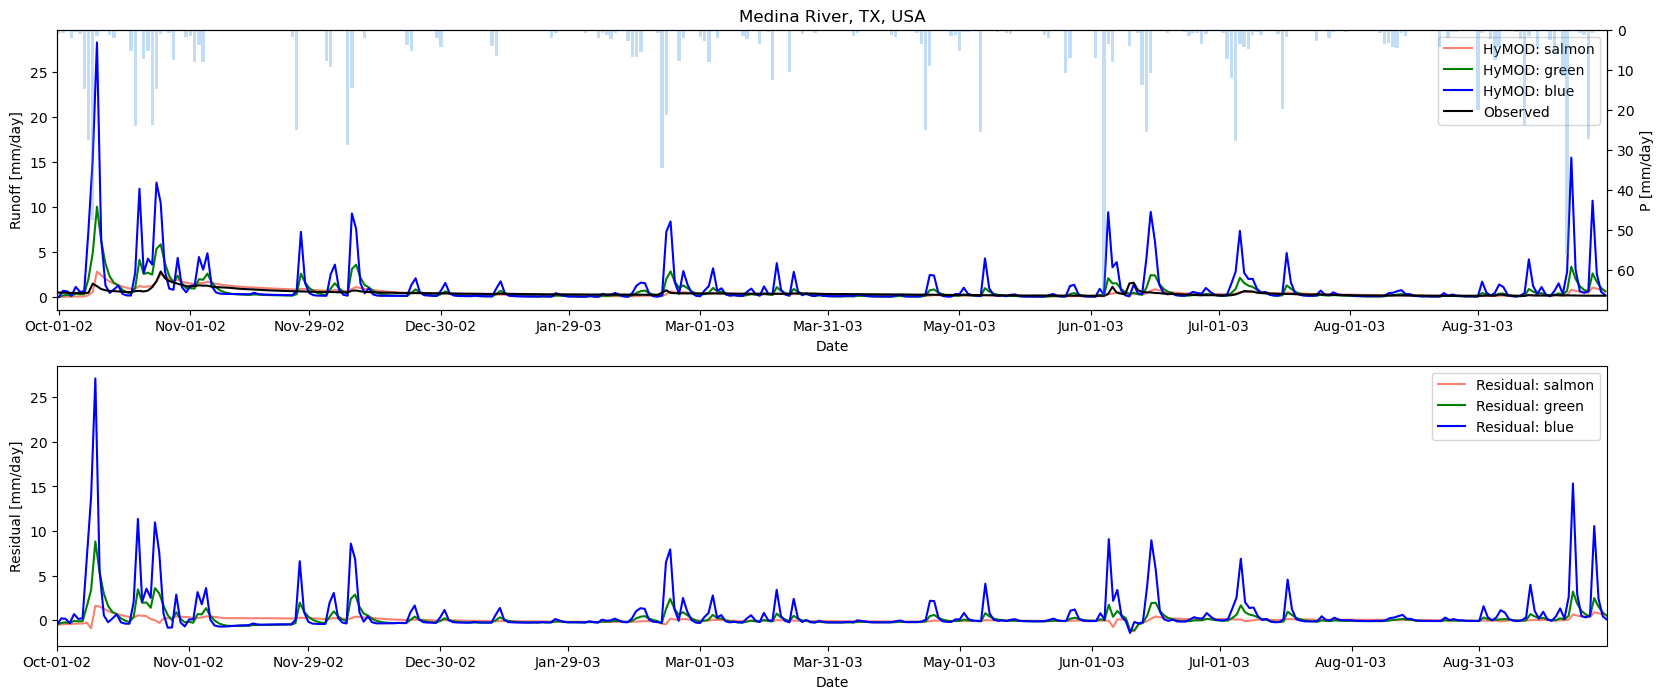

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
for obj_fun_name, color in zip(obj_fun_names, l_colors):
    # Run HyMOD simulation
    df_par_cat_obj_fun = df_par_catchment[df_par_catchment["objective_function"] == obj_fun_name]  # get the row with objective function name
    s_par_cat_obj_fun = df_par_cat_obj_fun.squeeze() # turn DataFrame into Series (https://pandas.pydata.org/docs/reference/api/pandas.Series.html)
    param = s_par_cat_obj_fun[["Sm", "beta", "alfa", "Rs", "Rf"]].to_numpy()
    print(f"Parameters for {catchment_name} ({color}): Sm={param[0]}, beta={param[1]}, alfa={param[2]}, Rs={param[3]}, Rf={param[4]}")
    q_sim, states, fluxes = HyMod.hymod_sim(param, P, evap)
    
    # Make Dataframe from results and calculate residual
    q_sim_col_name = f"Q_sim [mm/day]"
    residual_col_name = f"Residual [mm/day]"
    df_model = pd.DataFrame({q_sim_col_name: q_sim[-365:], 'ET [mm/day]': fluxes.T[0][-365:], 'Date': df_obs["Date"].to_numpy()})
    df_combined = df_obs.merge(df_model)  # merge the dataframe df_model onto df
    df_combined[residual_col_name] = df_combined[q_sim_col_name] - df_combined['Q [mm/day]'] # compute residual

    # Plot HyMOD result and residual
    model_label = f"HyMOD: {color}"
    residual_label = f"Residual: {color}"
    sns.lineplot(data=df_combined, x="Date", y=q_sim_col_name, ax=axes[0], label=model_label, color=color) # plot in upper plot: axes[0]
    sns.lineplot(data=df_combined, x="Date", y=residual_col_name, ax=axes[1], label=residual_label, color=color) # plot in lower plot: axes[1]

# Plot the simulated and observed Q
sns.lineplot(data=df_combined, x="Date", y="Q [mm/day]", ax=axes[0], color="black", label="Observed")

# Get the right hand side second y-axis and plot the precipitation as inverted bars
a1 = axes[0].twinx()
sns.barplot(data=df_obs, x="Date", y="P [mm/day]", ax=a1, color="dodgerblue", alpha=0.3)
a1.invert_yaxis()

for ax in axes:
    ax.xaxis.set_major_locator(mdate.MonthLocator()) # Show only the main ticks
    ax.margins(x=0) # reduce margin left and right of xaxis
    
axes[0].set_title(catchment_name)
axes[0].set_ylabel("Runoff [mm/day]")  # set y label of top plot

# Display the figure
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue;">
    <h4><span>&#129300 </span>Your Turn I: Comparing Simulated and Observed Hydrographs</h4>
    <ol>
        <li>What parts of the time series do the different model runs reproduce well or poorly? In other words: which features of the hydrograph do they capture well?</li>
        <li>How could you adjust these plots to see other aspects of model performance?</li>
        <li>What other aspects of model performance might be interesting but not captured in this plot?</li>
    </ol>
</div>

### 2.3. Using the Box-Cox Transformation

The [Box-Cox transformation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) is a family of power transformations used to stabilize variance and make data more normally distributed. It is particularly useful when dealing with data that shows heteroscedasticity or non-normality. The Box-Cox transformation is used to stabilize variance and improve the normality of data, which can enhance the performance of statistical methods that assume normally distributed errors.

The transformation is defined as:

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\log(y) & \text{if } \lambda = 0
\end{cases}
$$

where:
- $y$ is the original data value,
- $\lambda$ (lambda) is the transformation parameter,
- $y(\lambda)$ is the transformed data value.

The parameter $\lambda$ is typically chosen to maximize the log-likelihood function of the transformed data under the assumption of normality. Common values include $\lambda = 1$ (no transformation), $\lambda = 0.5$ (square root transformation), and $\lambda = -1$ (reciprocal transformation).

In [6]:
@interact(lmbda = (0.0, 1.0, 0.01))
def hymod_function(lmbda= 0.15):
    fig, axes = plt.subplots(2, 1, figsize=(20, 8))
    for obj_fun_name, color in zip(obj_fun_names, l_colors):    
        # Run HyMOD simulation
        df_par_cat_obj_fun = df_par_catchment[df_par_catchment["objective_function"] == obj_fun_name]  # get the row with objective function name
        s_par_cat_obj_fun = df_par_cat_obj_fun.squeeze() # turn DataFrame into Series (https://pandas.pydata.org/docs/reference/api/pandas.Series.html)
        param = s_par_cat_obj_fun[["Sm", "beta", "alfa", "Rs", "Rf"]].to_numpy()
        print(f"Parameters for {catchment_name} ({color}): Sm={param[0]}, beta={param[1]}, alfa={param[2]}, Rs={param[3]}, Rf={param[4]}")
        q_sim, states, fluxes = HyMod.hymod_sim(param, P, evap)
        
        # Make Dataframe from results and calculate residual
        q_sim_col_name = f"Q_sim [mm/day]"
        residual_col_name = f"Residual [mm/day]"
        df_model = pd.DataFrame({q_sim_col_name: q_sim[-365:], 'ET [mm/day]': fluxes.T[0][-365:], 'Date': df_obs["Date"].to_numpy()})
        df_combined = df_obs.merge(df_model)  # merge the dataframe df_model onto df
        df_combined[residual_col_name] = df_combined[q_sim_col_name] - df_combined['Q [mm/day]'] # compute residual        
        q_obs_col_name = 'Q [mm/day] (Box-Cox)'
        q_sim_col_name = 'Q_sim [mm/day] (Box-Cox)'
        
        # box cox transformation
        df_combined[q_obs_col_name] = scipy.stats.boxcox(df_combined['Q [mm/day]'].array, lmbda=lmbda)
        df_combined[q_sim_col_name] = scipy.stats.boxcox(df_combined['Q_sim [mm/day]'].array, lmbda=lmbda)
        
        # Plot Box-Cox-transformed runoffs and residual
        label = f"HyMOD (Box-Cox): {color}"
        sns.lineplot(data=df_combined, x="Date", y=q_sim_col_name, ax=axes[0], label=label, color=color) # plot in upper plot: axes[0]
        sns.lineplot(data=df_combined, x="Date", y="Residual [mm/day]", ax=axes[1], color=color) # plot residual in lower plot: axes[1]

    sns.lineplot(data=df_combined, x="Date", y=q_obs_col_name, ax=axes[0], color='black', label="Observed (Box-Cox)") # plot in upper plot: axes[0]
    
    # Get the right hand side second y-axis and plot the precipitation as inverted bars
    a1 = axes[0].twinx()
    sns.barplot(data=df_obs, x="Date", y="P [mm/day]", ax=a1, color="dodgerblue", alpha=0.3)
    a1.invert_yaxis()
    
    for ax in axes:
        ax.xaxis.set_major_locator(mdate.MonthLocator()) # Show only the main ticks
        ax.margins(x=0, y=0) # reduce margin left and right of xaxis

    axes[0].set_ylabel("Runoff [mm/day]")  # set y label of top plot

    # Display the figure
    plt.show()

interactive(children=(FloatSlider(value=0.15, description='lmbda', max=1.0, step=0.01), Output()), _dom_classe…

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue;">
    <h4><span>&#129300 </span>Your Turn II: Box-Cox Transformation</h4>
    <ol>
        <li>What benefits does the Box-Cox transformation offer?</li>
        <li>What is an optimal lambda-value for the Box-Cox transformation?</li>
    </ol>
</div>

### 2.4. Using scatter plots of observed values against simulated values to determine over- and underprediction

Parameters for Medina River, TX, USA (salmon): Sm=86.15, beta=0.257, alfa=0.548, Rs=0.17, Rf=0.082
Parameters for Medina River, TX, USA (green): Sm=269.822, beta=0.469, alfa=0.11, Rs=0.407, Rf=0.107
Parameters for Medina River, TX, USA (blue): Sm=186.299, beta=1.437, alfa=0.092, Rs=0.806, Rf=0.117


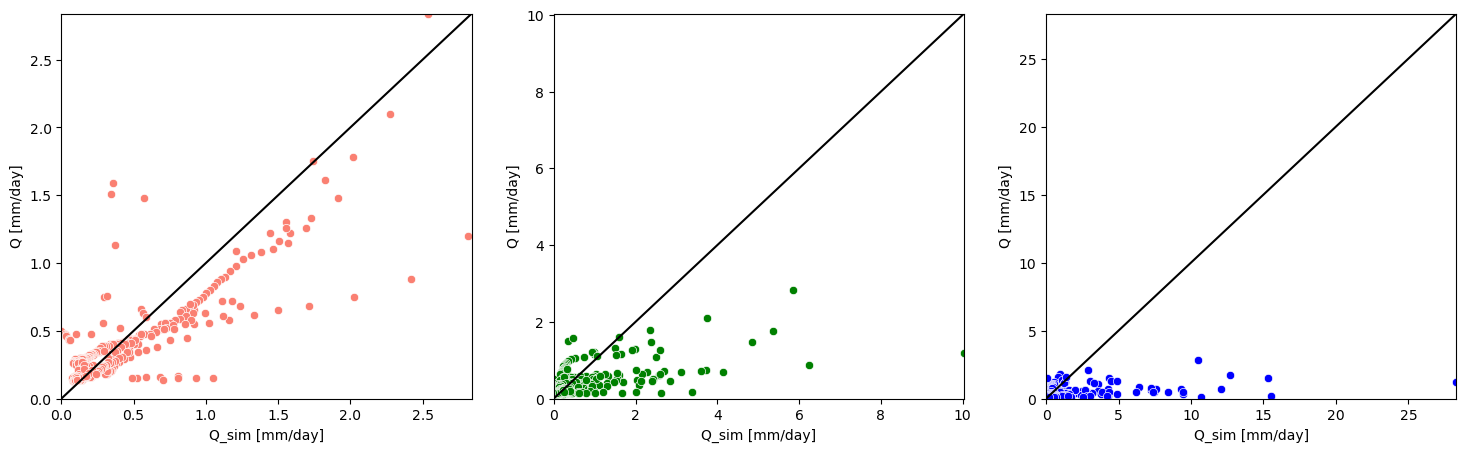

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
i = 0
for ax, obj_fun_name, color in zip(axes, obj_fun_names, l_colors):
    # Run HyMOD simulation
    df_par_cat_obj_fun = df_par_catchment[df_par_catchment["objective_function"] == obj_fun_name]  # get the row with objective function name
    s_par_cat_obj_fun = df_par_cat_obj_fun.squeeze() # turn DataFrame into Series (https://pandas.pydata.org/docs/reference/api/pandas.Series.html)
    param = s_par_cat_obj_fun[["Sm", "beta", "alfa", "Rs", "Rf"]].to_numpy()
    print(f"Parameters for {catchment_name} ({color}): Sm={param[0]}, beta={param[1]}, alfa={param[2]}, Rs={param[3]}, Rf={param[4]}")
    q_sim, states, fluxes = HyMod.hymod_sim(param, P, evap)
    
    # Make Dataframe from results
    q_sim_col_name = f"Q_sim [mm/day]"
    df_model = pd.DataFrame({q_sim_col_name: q_sim[-365:], 'ET [mm/day]': fluxes.T[0][-365:], 'Date': df_obs["Date"].to_numpy()})
    df_combined = df_obs.merge(df_model)  # merge the dataframe df_model onto df
    
    # Plot HyMOD results
    model_label = f"HyMOD: {obj_fun_name}"
    residual_label = f"Residual: {obj_fun_name}"
    max_runoff = max(df_combined[q_sim_col_name].max(), df_combined["Q [mm/day]"].max())
    ax.plot([0,max_runoff], [0,max_runoff], color="black")
    sns.scatterplot(data=df_combined, x=q_sim_col_name, y="Q [mm/day]", ax=ax, sizes=(1,1), color=color)
    ax.margins(x=0, y=0) # reduce margin left and right of xaxis

# Display the figure
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue">
    <h4><span>&#129300 </span>Your Turn III: Using scatter plots to determine over- and underprediction</h4>
    The above plots show scatter plots of observed against simulated runoff. The simulation results were calibrated differently.
    <ol>
        <li>What does each individual scatter plot tell you about the model performance in simulating runoff? Are low flow periods and peak flows accurately simulated?</li>
        <li>Can you think of ways to adjust the scatterplot so that they could be even more informative? Implement your idea in the code!</li>
    </ol>
</div>

### 2.5. Analysing Residuals

In the context of the HyMOD hydrological model, model residuals represent the differences between observed streamflow values and those predicted by the model. They are a measure of the model's performance in capturing the actual hydrological behavior.

For a given time step, the residual is calculated as:

$$
\text{Residual} = \text{Observed Streamflow} - \text{Predicted Streamflow}
$$

Analyzing residuals helps assess the accuracy of the HyMOD model. Ideally, residuals should be randomly distributed with no discernible pattern, indicating that the model effectively represents the underlying hydrological processes. Patterns or systematic deviations in residuals may suggest areas where the model could be improved, such as adjustments to parameters or incorporation of additional factors.

Parameters for Medina River, TX, USA (salmon): Sm=86.15, beta=0.257, alfa=0.548, Rs=0.17, Rf=0.082
Parameters for Medina River, TX, USA (green): Sm=269.822, beta=0.469, alfa=0.11, Rs=0.407, Rf=0.107
Parameters for Medina River, TX, USA (blue): Sm=186.299, beta=1.437, alfa=0.092, Rs=0.806, Rf=0.117


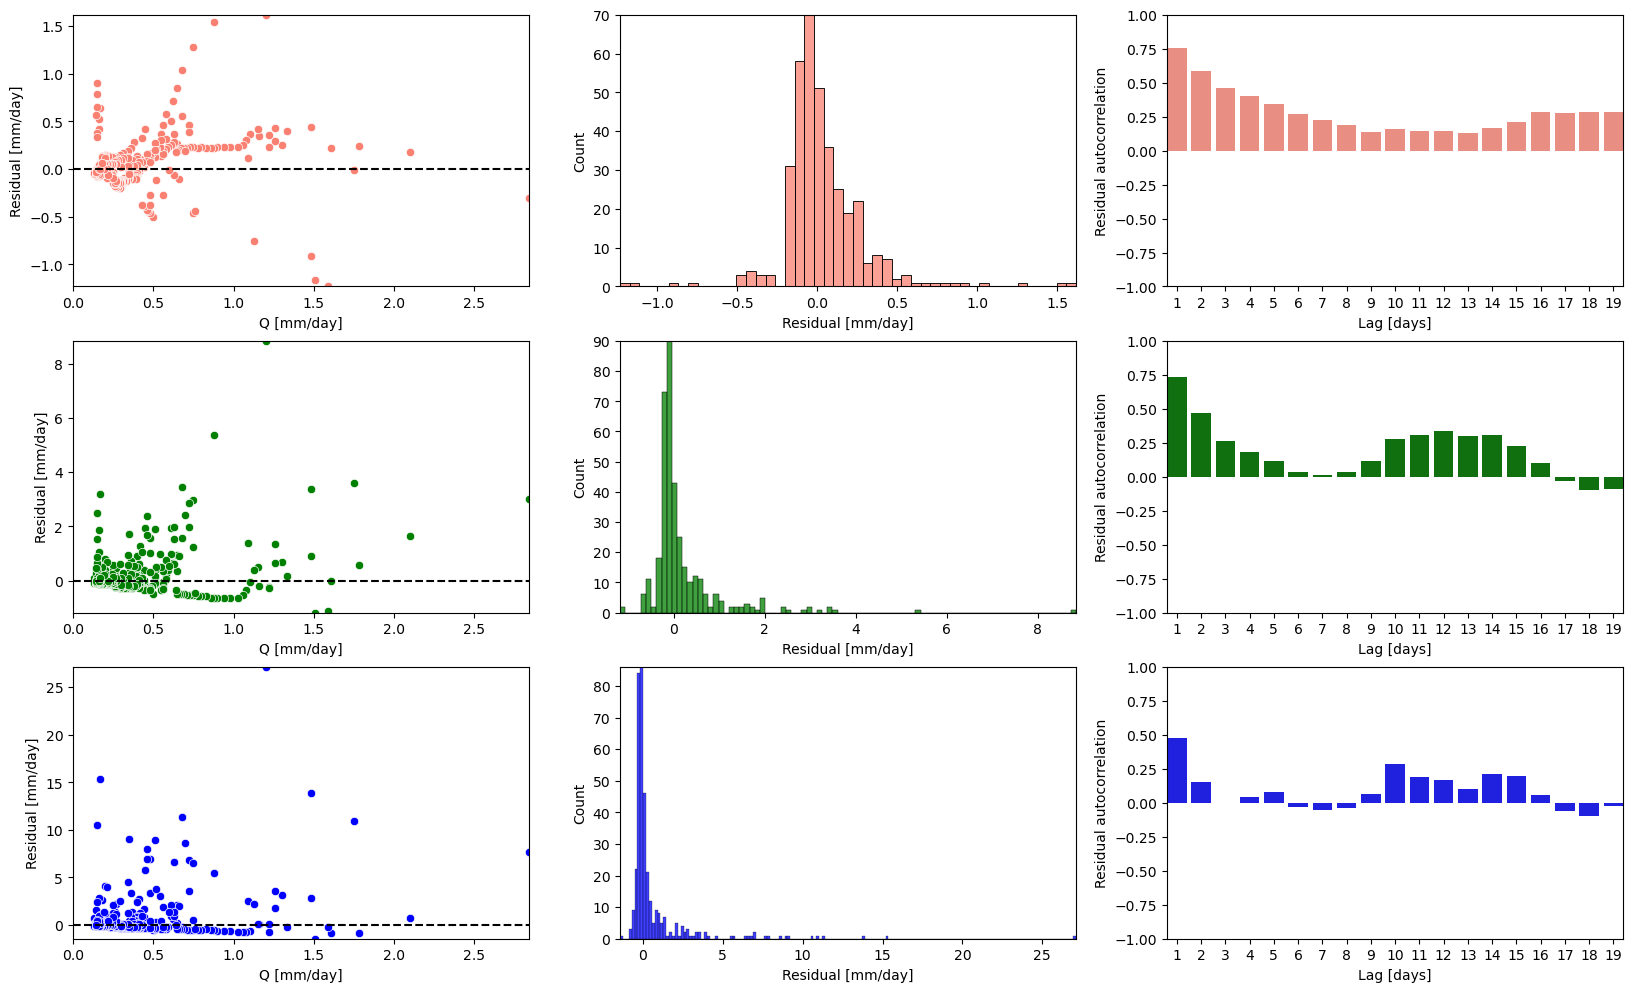

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
i = 0
for obj_fun_name, color in zip(obj_fun_names, l_colors):
    # Run HyMOD simulation
    df_par_cat_obj_fun = df_par_catchment[df_par_catchment["objective_function"] == obj_fun_name]  # get the row with objective function name
    s_par_cat_obj_fun = df_par_cat_obj_fun.squeeze() # turn DataFrame into Series (https://pandas.pydata.org/docs/reference/api/pandas.Series.html)
    param = s_par_cat_obj_fun[["Sm", "beta", "alfa", "Rs", "Rf"]].to_numpy()
    print(f"Parameters for {catchment_name} ({color}): Sm={param[0]}, beta={param[1]}, alfa={param[2]}, Rs={param[3]}, Rf={param[4]}")
    q_sim, states, fluxes = HyMod.hymod_sim(param, P, evap)
    
    # Make Dataframe from results and calculate residual
    q_sim_col_name = f"Q_sim [mm/day]"
    residual_col_name = f"Residual [mm/day]"
    df_model = pd.DataFrame({q_sim_col_name: q_sim[-365:], 'ET [mm/day]': fluxes.T[0][-365:], 'Date': df_obs["Date"].to_numpy()})
    df_combined = df_obs.merge(df_model)  # merge the dataframe df_model onto df
    df_combined[residual_col_name] = df_combined[q_sim_col_name] - df_combined['Q [mm/day]'] # compute residual    
    # First plot: Residual on y-axis, observations on x-axis
    axes[i][0].plot([0, df_combined['Q [mm/day]'].max()], [0, 0], linestyle="--", color="black")
    sns.scatterplot(data=df_combined, x='Q [mm/day]', y=residual_col_name, ax=axes[i][0], color=color)
    
    # Second plot: Distribution of residual values
    sns.histplot(data=df_combined, x=residual_col_name, ax=axes[i][1], color=color)
    
    # Third plot: residual autocorrelation
    max_lag = 20
    df_shifted = pd.DataFrame(df_combined[residual_col_name]) # initialize dataframe holding the shifted residual values with residuals at t0
    for lag in range(1, max_lag):
        col_name = f"t{lag}" # define column name (t1, t2...)
        df_shifted[col_name] = df_combined[residual_col_name].shift(lag) # create new column, shifted by current lag
    df_autocorr = df_shifted.corr() # compute correlation between the shifted columns
    df_autocorr = df_autocorr.reset_index(drop=True).reset_index() # reindex twice so we get a column counting up from 1
    df_autocorr = df_autocorr.iloc[1: , :] # drop the first row
    df_autocorr = df_autocorr.rename(columns={residual_col_name: "Residual autocorrelation", "index":"Lag [days]"}) # rename columns for ax labeling
    sns.barplot(data=df_autocorr, y="Residual autocorrelation", x="Lag [days]", ax=axes[i][2], color=color)
    axes[i][2].set_ylim(bottom=-1,top=1)
    # Reduce margin on x and y-axis
    axes[i][0].margins(x=0, y=0) 
    axes[i][1].margins(x=0, y=0)
    axes[i][2].margins(x=0, y=0)
    
    i += 1

# Display the figure
plt.show()

<div style="background:#e0f2fe; padding: 1%; border:1mm solid SkyBlue">
    <h4><span>&#129300 </span>Your Turn IV: Analysing Residuals</h4>
    <ol>
        <li>What can you learn from these residual scatter plot?</li>
        <li>What can you learn from the residual distribution in general?</li>
        <li>What can you learn from the residual <a href="https://en.wikipedia.org/wiki/Autocorrelation">autocorrelation?</a></li>
    </ol>
</div>